# **Importing the initial needed libraries**

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os

#Multithreading
from multiprocessing.dummy import Pool as ThreadPool


import optuna
from sklearn.ensemble import RandomForestRegressor as rf
from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgb
from sklearn.model_selection import cross_val_score

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import config # to hide TMDB API keys
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )
api_key = config.api_key

#NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
import string

#SHAP
import shap

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karlountalan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing the datasets downloaded from IMDB site**



*   title.ratings.tsv - contains the ratings for each IMDB ID
*   title.basics.tsv.gz - contains the titles and other main details for each IMDD movie ID
*   title.principals.tsv.gz - contains the crew ID of the directors and casts for each IMDB movie ID
*   name.basics.tsv.gz - contains the name for each IMDB name ID (crew ID)



In [ ]:
df_ratings = pd.read_csv('/Users/karlountalan/Downloads/title.ratings.tsv.gz', compression='gzip', header=0, sep='\t', quotechar='"')
df_titles = pd.read_csv('/Users/karlountalan/Downloads/title.basics.tsv.gz', compression='gzip', header=0, sep='\t', quotechar='"')
df_titles_principals = pd.read_csv('/Users/karlountalan/Downloads/title.principals.tsv.gz', compression='gzip', header=0, sep='\t', quotechar='"')
df_names = pd.read_csv('/Users/karlountalan/Downloads/name.basics.tsv.gz', compression='gzip', header=0, sep='\t', quotechar='"')

/Users/karlountalan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# **Data Wrangling and Analysis**



1.   We need to only get the MOVIES in the dataset since the data set includes many categories like tv shows and series.
2.   We are going to join the tables using the IMDB IDs to produce a single dataframe with the data we need like the titles, ratings, directors, cast, and etc.
3.   There are some null values and they are labeled as "\\N" so we're going to replace that with np.nan.
4.   We also drop the original title since we can use the Primary title.
5.   Also dropping the EndYear column since movies have the same startYear and EndYear.
6.   There are 24 movies with no startYear. Removing those rows since those values are only less than 1% of our whole data.


In [ ]:
df_titles = df_titles[df_titles['titleType']=='movie'] # Getting only the movies from the imdb dataset
df_all = pd.merge(df_titles,df_ratings,how='left',on='tconst')
df_all = df_all[pd.notnull(df_all['numVotes'])]
df_all.replace('\\N',np.nan,inplace=True) #Replacing \\N values with null
df_all['startYear'] = df_all['startYear'].astype(float)
df_all['runtimeMinutes'] = df_all['runtimeMinutes'].astype(float)
df_all.drop(['originalTitle','endYear'],axis=1,inplace=True)#Dropping Original Title because we can use the Primary Title (English Translated for most)
#Also dropping EndYear because this is a Movie analysis not series
df_all = df_all[pd.notnull(df_all['startYear'])] #Removing the 24 rows with no startYear value

Joining the directors and cast with the IMDB cast ID and then joining them with their appropriate movie title.

If there are multiple director and actors/actress, we would separate it with a comma.

In [ ]:
df_directors = df_titles_principals[df_titles_principals['category']=='director']
df_director_code = pd.merge(df_all[['tconst']],df_directors[['tconst','nconst']],on='tconst',how='inner')
df_director_code = pd.merge(df_director_code,df_names[['nconst','primaryName']],on='nconst',how='inner')
df_title_directors = df_director_code.groupby(['tconst']).agg({'primaryName': ','.join}).reset_index()
df_all = pd.merge(df_all,df_title_directors[['tconst','primaryName']],on='tconst',how='left')
df_all.rename(columns={'primaryName':'director'},inplace=True)


df_cast = df_titles_principals[(df_titles_principals['category']=='actor') | (df_titles_principals['category']=='actress')]
df_act_year = pd.merge(df_all[['tconst','primaryTitle','startYear']],df_cast[['tconst','nconst','category']],on='tconst',how='inner')
df_act_year = pd.merge(df_act_year,df_names[['nconst','primaryName']],on='nconst',how='inner')
df_title_actors = df_act_year.groupby(['tconst','primaryTitle']).agg({'primaryName': ','.join})
df_all = pd.merge(df_all,df_title_actors,how='left',on='tconst')
df_all.rename(columns={'primaryName':'cast'},inplace=True)

# **Weighted Rating Calculation**

<img src="https://i.ibb.co/2qF4xNM/ratingform.png" width=1000 height=400 />

Source: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#

Above is the formula in calculating the weighted ratings for each movies based on their mean rating on IMDB and the number of votes.

We get both their weighted rating for "All-time" and for their respective Movie debut years. (C value will vary)

In [ ]:
ratingmeandict = {} # Getting the mean of the ratings per year for the sameYear rating calculation 
popularitydict = {} # Getting the sum of the numVotes per year for the Weighted Populariy calculation 
for year in df_all['startYear'].unique():
    ratingmeandict[year] = df_all[df_all['startYear']==year]['averageRating'].mean()
    popularitydict[year] = df_all[df_all['startYear']==year]['numVotes'].sum()

In [ ]:
#Getting the weightedRating for all time and for same year for each movies
df_all['weightedRating_allTime'] = ((df_all['numVotes']/(df_all['numVotes']+25000))*df_all['averageRating']) + ((25000/(df_all['numVotes']+25000))*df_all['averageRating'].mean())
df_all['weightedRating_sameYear'] =  df_all.apply(lambda row: ((row['numVotes']/(row['numVotes']+25000))*row['averageRating']) + ((25000/(row['numVotes']+25000))*ratingmeandict[row['startYear']]) if pd.notnull(row['startYear']) else np.nan, axis=1)

## **Highest Rated Movie in 2018**

Based from the data, the highest rated movie in 2018 is obviously the **Avengers: Infinity War**

Please refer to the table below for the top 5 movies in ratings for 2018

In [ ]:
df_2018 = df_all[df_all['startYear']==2018]

In [ ]:
df_2018.sort_values(['weightedRating_sameYear'],ascending=False)[['primaryTitle','weightedRating_sameYear']].head(5)

,primaryTitle,weightedRating_sameYear
220007,Avengers: Infinity War,8.337009
224707,Spider-Man: Into the Spider-Verse,8.265777
246172,Green Book,8.079002
178671,Bohemian Rhapsody,7.905534
254665,Capernaum,7.791809


# **Movie Popularity Calculation**

<img src="https://latex.codecogs.com/gif.latex?P&space;=&space;\frac{numVotes*100}{total&space;year&space;numVotes}" title="P = \frac{numVotes*100}{total year numVotes}" />

To get the movie popularity score for each movie, we get the total votes of that movie and divide it by the summation of the total votes in the same year as the movie's start year

In [ ]:
#Getting the popularityratio per movie for the most popular actor award
df_all['popularityRatio'] = df_all.apply(lambda row: (row['numVotes']*100/popularitydict[row['startYear']]),axis=1)

In [ ]:
df_act_year = pd.merge(df_act_year,df_all[['tconst','popularityRatio']],on='tconst',how='left')
actors = df_act_year.groupby(['startYear','primaryName'])['popularityRatio'].sum().reset_index()

## **Most Popular Actor/Actress in 2018**

The most popular actor in 2018 is **Chris Hemsworth**

He is followed by the main characters of the movie **Avengers**

The reason that Chris Hemsworth has higher popularity ratio score than the other characters of the avengers is because Chris also has other movies that were popular in 2018 that boosted his popularity score

In [ ]:
actors[actors['startYear']==2018].sort_values(['popularityRatio'],ascending=False)

,startYear,primaryName,popularityRatio
709970,2018.0,Chris Hemsworth,3.804321
726536,2018.0,Robert Downey Jr.,3.521552
721453,2018.0,Mark Ruffalo,3.521552
709960,2018.0,Chris Evans,3.521552
720698,2018.0,Mahershala Ali,3.215714
...,...,...,...
730729,2018.0,Troy D. Williams,0.000020
714158,2018.0,Graham Bui,0.000020
717961,2018.0,Junji Majima,0.000020
714167,2018.0,Grant Foster,0.000020


# **Movie Runtimes**

In [ ]:
df_runtime = df_all.groupby('startYear').agg({'runtimeMinutes':'mean'}).reset_index().sort_values('startYear')

In [ ]:
df_runtime = df_runtime[df_runtime['startYear']>=1940]

## Average Runtime in Minutes of Movies per Year

Since the year 1960, the average runtime per movie per year ranges from approximately 93 to 100 minutes.



In [ ]:
fig = px.line(df_runtime, x="startYear", y="runtimeMinutes", title='Average Runtime of Movies per Year')
fig.show()

## **All-time Movie with the Longest Runtime**

The longest movie runtime ever in IMDB database is the documentary movie **Logistics** which was released last 2012. This Movie has a runtime of almost **36 continuous days**!

Please refer to the table below for the top 5 movies with the longest runtime

In [ ]:
df_all.sort_values('runtimeMinutes',ascending=False)[['primaryTitle','startYear','genres','runtimeMinutes']].head(5)

,primaryTitle,startYear,genres,runtimeMinutes
254703,Logistics,2012.0,Documentary,51420.0
201782,Modern Times Forever,2011.0,Documentary,14400.0
149691,Qw,2019.0,Drama,10062.0
196261,Beijing 2003,2004.0,Documentary,9000.0
105867,The Cure for Insomnia,1987.0,"Documentary,Music",5220.0


# **Genre Trends**






*   We only consider movies from 1940 since there are VERY FEW movies before that.
*   We will get the ratio of the total number of counts of each genre per year to the total number of all genre count per year so that we can clearly see the trends without worrying about the increasing number of movies produced as years go by





In [ ]:
genres = pd.concat([df_all['startYear'], df_all['genres'].str.get_dummies(sep=',',)],axis=1)
genres = genres.groupby('startYear').sum().reset_index()
genres = genres[genres['startYear']>=1940].reset_index(drop=True)

title_counts = {}
for i,row in genres.iterrows():
    title_counts[row['startYear']] = genres.iloc[i,1:].sum()
genres = genres.melt(id_vars='startYear',value_vars = genres.columns[1:])
genres['pct'] = genres.apply(lambda row: row['value']*100/title_counts[row['startYear']],axis=1)
genres.columns = ['year','genre','total','pct']

## **Trend Observations for the Past 10 Years**


*   The most produced movie genre, Drama, stayed in its position for the past 10 years which accounts to almost a quarter of all the movies.
*   Documentary and Comedy, somehow declined in numbers for the last 10 years.
*   Thriller genre increased in numbers for the last 10 years and made a significant increase from year 2020 to 2021.
*   There are not much significant changes for the other genres



In [ ]:
fig = px.line(genres[genres['year']>=2010], x="year", y="pct", color='genre')
fig.show()

## **Wider View of the Trend changes since 1940**


*   Since the 1960s we can clearly see a decline in numbers of movies with Drama and Comedy genre
*   Starting 1980s action movies also declined in numbers
*   We can clearly see that there is a significant increase in the trend of the Documentary Genre since 1990
*   The trend of the Thriller movies also increased since 1940



In [ ]:
fig = px.line(genres, x="year", y="pct", color='genre')
fig.show()

# **Acquisition of Movies' Revenue, Budget, and Description Data**



*   We will use the TMDB API in getting the data of the Revenue and Budget of IMDB movies
*   To avoid lots of request in the API, we will only get the top 100 (according to weightedRating) movies per year for the past 50 years



In [ ]:
dfs_50 = pd.DataFrame()
years = [x for x in df_all['startYear'].unique() if ((x>(2020-50)))]
for year in years:
    df_yr = df_all[df_all['startYear']==year].sort_values(['weightedRating_sameYear'],ascending=False).reset_index(drop=True).iloc[0:100]
    dfs_50 = dfs_50.append(df_yr)

Function definition in getting the revenue, budget, and description using the IMDB ID of the movie

In [ ]:
def get_rev_bud(tconst):
    try:
        response = requests.get('https://api.themoviedb.org/3/find/'+tconst+'?api_key='+ api_key+'&language=en-US&external_source=imdb_id')
        mid = response.json()['movie_results'][0]['id']
        movie = requests.get('https://api.themoviedb.org/3/movie/'+ str(mid) +'?api_key='+ api_key+'&language=en-US')
        try:
            revenue = movie.json()['revenue']
        except:
            revenue = 0
        try:
            budget = movie.json()['budget']
        except:
            revenue = 0
        try:
            desc = movie.json()['overview']
        except:
            desc = np.nan
    except:
        revenue = 0
        budget = 0
        desc = np.nan
    finally:
        if revenue == 0:
            revenue = np.nan
        if budget == 0:
            budget == np.nan
    return (tconst,revenue,budget,desc)

Since there is not Rate limiter according to the API documentation, we will use multithreading for faster api requests using parallelism

In [ ]:
imdb_ids = dfs_50['tconst'].tolist()
pool = ThreadPool(processes=50)  # Make the Pool of workers
res = pool.map(get_rev_bud, imdb_ids) #Open the urls in their own threads
pool.close() #close the pool and wait for the work to finish 

In [ ]:
df_revbud = pd.DataFrame(res,columns=['tconst','revenue','budget','description'])
df_revbud.dropna(inplace=True)
df_revbud['profit'] = df_revbud['revenue'] - df_revbud['budget']
df_top_100 = pd.merge(dfs_50,df_revbud,on='tconst',how='inner')
df_100 = df_top_100.copy()
df_100[['revenue','budget','profit']] = df_100[['revenue','budget','profit']]/1000000

## Top Movies with the Highest Profit for the Past 50 Years (in Millions)

The highest grossing movie ever is the movie **Avatar** with over 2.5 Billion USD in profits! 

In [ ]:
df_100.sort_values(['profit'],ascending=False).head(10)[['primaryTitle','startYear','revenue','budget','profit']]

,primaryTitle,startYear,revenue,budget,profit
2559,Avatar,2009.0,2787.965087,237.0,2550.965087
2,Avengers: Endgame,2019.0,2797.800564,356.0,2441.800564
2160,Titanic,1997.0,2187.463944,200.0,1987.463944
2728,Star Wars: Episode VII - The Force Awakens,2015.0,2068.223624,245.0,1823.223624
1160,Avengers: Infinity War,2018.0,2046.239637,300.0,1746.239637
2770,Jurassic World,2015.0,1671.713208,150.0,1521.713208
45,The Lion King,2019.0,1656.943394,260.0,1396.943394
2758,Furious 7,2015.0,1515.047671,190.0,1325.047671
46,Frozen II,2019.0,1450.026933,150.0,1300.026933
2806,The Avengers,2012.0,1518.815515,220.0,1298.815515


In [ ]:
df_top_100

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,director,cast,weightedRating_allTime,weightedRating_sameYear,popularityRatio,revenue,budget,description,profit
0,tt6751668,movie,Parasite,0,2019.0,132.0,"Comedy,Drama,Thriller",8.6,593743.0,Bong Joon Ho,"Kang-ho Song,Sun-kyun Lee,Yeo-jeong Cho,Woo-si...",8.500519,8.501491,2.511561,2.575918e+08,11363000,"All unemployed, Ki-taek's family takes peculia...",2.462288e+08
1,tt7286456,movie,Joker,0,2019.0,122.0,"Crime,Drama,Thriller",8.4,984379.0,Todd Phillips,"Robert De Niro,Joaquin Phoenix,Frances Conroy,...",8.343972,8.344568,4.163969,1.074251e+09,55000000,"During the 1980s, a failed stand-up comedian i...",1.019251e+09
2,tt4154796,movie,Avengers: Endgame,0,2019.0,181.0,"Action,Adventure,Drama",8.4,859567.0,"Anthony Russo,Joe Russo","Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...",8.336067,8.336746,3.636008,2.797801e+09,356000000,After the devastating events of Avengers: Infi...,2.441801e+09
3,tt8579674,movie,1917,0,2019.0,119.0,"Drama,Thriller,War",8.3,453132.0,Sam Mendes,"Colin Firth,Daniel Mays,George MacKay,Dean-Cha...",8.186949,8.188206,1.916769,3.747339e+08,100000000,"At the height of the First World War, two youn...",2.747339e+08
4,tt1950186,movie,Ford v Ferrari,0,2019.0,152.0,"Action,Biography,Drama",8.1,308110.0,James Mangold,"Christian Bale,Matt Damon,Jon Bernthal,Caitrio...",7.952742,7.954546,1.303320,2.255082e+08,97600000,American car designer Carroll Shelby and the B...,1.279082e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,tt5221584,movie,Aquarius,0,2016.0,146.0,Drama,7.5,18607.0,Kleber Mendonça Filho,"Sônia Braga,Irandhir Santos,Maeve Jinkings,Hum...",6.719090,6.783745,0.058940,2.859300e+05,762241,"Clara, a 65-year-old widow and retired music c...",-4.763110e+05
2971,tt4420704,movie,Kedi,0,2016.0,79.0,Documentary,7.7,13445.0,Ceyda Torun,NaN,6.684181,6.757518,0.042589,5.037923e+06,0,"A profile of Istanbul and its unique people, s...",5.037923e+06
2972,tt5278506,movie,Tickled,0,2016.0,92.0,"Crime,Documentary,Mystery",7.5,16924.0,NaN,NaN,6.687741,6.754992,0.053609,9.230000e+05,0,Journalist David Farrier stumbles upon a myste...,9.230000e+05
2973,tt0803096,movie,Warcraft,0,2016.0,123.0,"Action,Adventure,Fantasy",6.8,243875.0,Duncan Jones,"Ben Foster,Paula Patton,Travis Fimmel,Dominic ...",6.738436,6.748922,0.772505,4.336772e+08,160000000,The peaceful realm of Azeroth stands on the br...,2.736772e+08


## **Genre and Revenue Analysis**

Based from the boxplot below, we can see that the **Action, Adventure, Animation, Sci-Fi, Fantasy, Family** had access to the bigger revenue among the other genres. 

In [ ]:
fig = px.line(genres, x="year", y="pct", color='genre')
fig.show()

In [ ]:
genre_rev_df = pd.concat([pd.Series(row['revenue'], row['genres'].split(','))              
                    for _, row in df_top_100.iterrows()]).reset_index()
genre_rev_df.columns = ['genre','revenue']
fig = px.box(genre_rev_df, x="genre", y="revenue",)
fig.show()

# **Pre-Modeling Data Cleaning**

We will only use the data for the past 15 years in producing a model

In [ ]:
df_top = df_top_100[df_top_100['startYear']>(2021-15)]

Dropping unnecessary columns for modeling

In [ ]:
#removing the isAdult column because 99% of the data has a 0 vaue for isAdult
df_top.drop(['isAdult'],axis=1,inplace=True)

#removing the unneccesary columns for training data
df_top.drop(['tconst','titleType','primaryTitle','popularityRatio'],axis=1,inplace=True)

#removing the numVotes and other ratings variables to avoid data leakage
df_top.drop(['averageRating','numVotes','weightedRating_allTime','weightedRating_sameYear','profit'],axis=1,inplace=True)

/Users/karlountalan/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Getting the sample weights array for giving more weights to the most recent data

In [ ]:
wts = df_top['startYear']-df_top['startYear'].min()
df_top.drop(['startYear'],axis=1,inplace=True)

## **Encoding the Cast and Directors into Dummy Variables**

We will only consider the names with occurence of **above 2x** in our data

In [ ]:
def encoded_column_df(col,prefix):
    full_df = col.str.get_dummies(sep=',',).add_prefix(prefix)
    full_df = full_df[full_df.sum()[lambda x: x>2].index]
    return full_df

In [ ]:
df = df_top[['runtimeMinutes','genres','director','cast','budget','revenue','description']].reset_index(drop=True)
df = pd.concat([df.drop('director',axis=1), encoded_column_df(df['director'],'dir_')],axis=1)
df = pd.concat([df.drop('cast',axis=1), encoded_column_df(df['cast'],'cast_')],axis=1)

## **Encoding the Genres Into Dummy Variables**

In [ ]:
df = pd.concat([df.drop('genres',axis=1), df['genres'].str.get_dummies(sep=',',).add_prefix('genre_')],axis=1)

## **NLP for the Description Column**

Producing a wordcloud for the description feature that shows the top 100 most frequent words used in our dataset

Some most frequent words are **family, friend, life, world, find,** and etc.

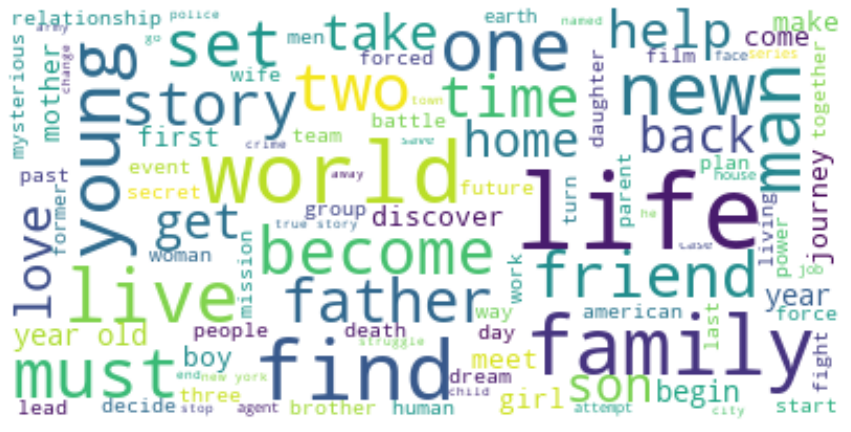

In [ ]:
descriptions = df['description'].str.lower().str.split()
all_desc = []
for text in descriptions:
    text = [x.strip(string.punctuation) for x in text]
    all_desc.append(text)

all_desc = [" ".join(text) for text in all_desc]
all_desc = " ".join(all_desc)
sw = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=sw, background_color="white", max_font_size=50, max_words=100).generate(all_desc)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Creating the Bag of Words

In [ ]:
corpus = []
for i in range(0, len(df)):
    desc = re.sub('[^a-zA-Z]', ' ' ,df['description'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    desc = [ps.stem(word) for word in desc if not word in set(stopwords.words('english'))]
    desc = ' '.join(desc)
    corpus.append(desc)

Count Vectorizing the words in the bag of words and then encoding it as columns of our main dataframe

We will only consider the top 1500 most used words

In [ ]:
cv = CountVectorizer(max_features = 1500)
cv_x = cv.fit_transform(corpus)
cv_df = pd.DataFrame(cv_x.todense(), columns=cv.get_feature_names())
df = pd.concat([df.drop('description',axis=1), cv_df],axis=1)

# **Modeling**

## Correlation plot of the popularity score, weighted rating, and the revenue

Based from the figure below, we will be using **revenue** as our **target variable.**

Both the Popularity score and the weighted rating score have a **high positive correlation** value with the revenue.

The higher the weighted ranking and the popularity score a movie has, the higher revenue it produces.

Hence, we can use this revenue variable as our **metric** to determine if a movie is a **"hit"**

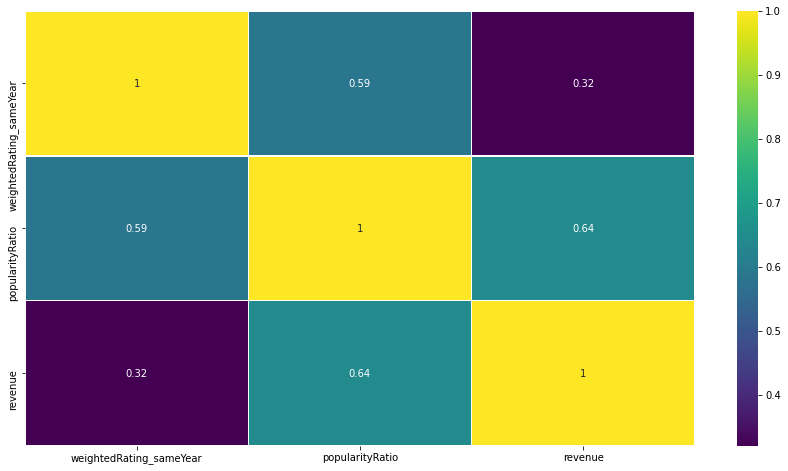

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df_top_100[['weightedRating_sameYear','popularityRatio','revenue']].corr(),annot=True,cmap='viridis',linewidths=0.1,
            linecolor='w')

## Normalizing the skewed features

Since the features runtime, budget, and revenue are skewed, we will normalize it using log1p function

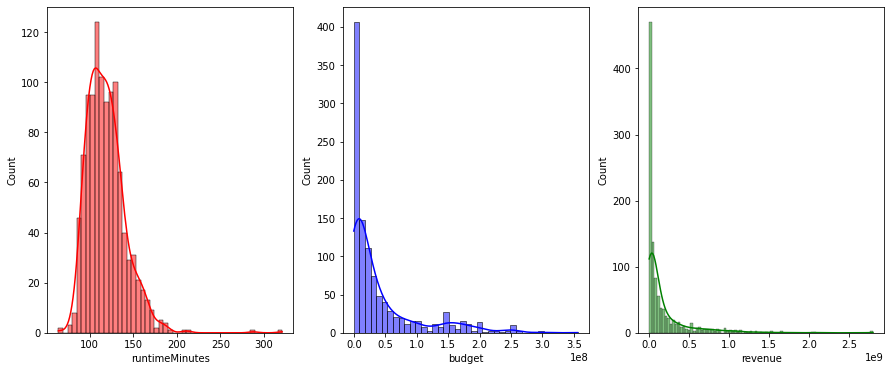

In [ ]:
g,axes = plt.subplots(1,3, figsize=(15,6))
sns.histplot(df['runtimeMinutes'],ax=axes[0],kde=True,color='r')
sns.histplot(df['budget'],ax=axes[1],kde=True,color='b')
sns.histplot(df['revenue'],ax=axes[2],kde=True,color='g')

In [ ]:
df['runtimeMinutes'] = np.log1p(df['runtimeMinutes'])
df['budget'] = np.log1p(df['budget'])
df['revenue'] = np.log1p(df['revenue'])

Our data is now ready for modeling!

In [ ]:
df.head()

,runtimeMinutes,budget,revenue,dir_Adam McKay,dir_Alejandro G. Iñárritu,dir_Anthony Russo,dir_Antoine Fuqua,dir_Anurag Kashyap,dir_Asghar Farhadi,dir_Bong Joon Ho,dir_Brad Bird,dir_Bryan Singer,dir_Byron Howard,dir_Cary Joji Fukunaga,dir_Chad Stahelski,dir_Chris Sanders,dir_Chris Williams,dir_Christopher McQuarrie,dir_Christopher Miller,dir_Christopher Nolan,dir_Clint Eastwood,dir_Craig Gillespie,dir_Damien Chazelle,dir_Danny Boyle,dir_David Ayer,dir_David Fincher,dir_David Mackenzie,dir_David O. Russell,dir_David Yates,dir_Dean DeBlois,dir_Denis Villeneuve,dir_Derek Cianfrance,dir_Destin Daniel Cretton,dir_Don Hall,dir_Duncan Jones,dir_Edgar Wright,dir_Ethan Coen,dir_Fatih Akin,dir_Francis Lawrence,dir_Gavin O'Connor,...,wick,widow,wife,wild,wilder,will,william,wilson,win,wing,winter,wire,wish,wit,within,without,wizard,woman,women,wonder,wood,word,work,worker,world,worst,would,wrestl,write,writer,wrong,year,yet,york,young,younger,youth,zombi,zone,zoo
0,4.890349,16.245873,19.366887,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.812184,17.822844,20.794890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.204007,19.690441,21.752099,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.787492,18.420681,19.741727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5.030438,18.396388,19.233867,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Separating the Independent Variables and the Target Variable**

In [ ]:
x = df.drop(['revenue'],axis=1)
y = df['revenue']

## **Model Selection and Hyperparameter Optimization using Optuna Framework**

In [ ]:
def objective(trial):
    regressor = trial.suggest_categorical('regressor',['RF','XGB','LGB'])
    if regressor == 'RF':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 100, 1000,100)
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 1, 32))
        rf_bootstrap = trial.suggest_categorical('rf_bootstrap',[True,False])
        rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf',1,5,1)
        rf_max_features = trial.suggest_categorical('rf_max_features',['auto','log2','sqrt'])
        regressor_obj = rf(n_estimators=rf_n_estimators, max_depth=rf_max_depth,min_samples_leaf=rf_min_samples_leaf,
                                bootstrap=rf_bootstrap,max_features=rf_max_features,random_state=42)
    elif regressor == 'XGB':
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 2000,200)
        xgb_learning_rate = trial.suggest_uniform('xgb_learning_rate',0.01,1)
        xgb_min_child_weight = trial.suggest_int('xgb_min_child_weight',1,3,1)
        regressor_obj = xgb(n_estimators=xgb_n_estimators,learning_rate=xgb_learning_rate,min_child_weight=xgb_min_child_weight,
                           random_state=42,n_jobs=-1)
    else:
        lgb_n_estimators = trial.suggest_int('lgb_n_estimators', 100, 2000,200)
        lgb_boosting_type = trial.suggest_categorical('lgb_boosting_type',['gbdt','dart','goss'])
        lgb_learning_rate = trial.suggest_uniform('lgb_learning_rate',0.01,1)
        lgb_num_leaves = trial.suggest_int('lgb_num_leaves',20,1000,50)
        lgb_max_depth = int(trial.suggest_loguniform('lgb_max_depth', 1, 32))
        regressor_obj = lgb(n_estimators=lgb_n_estimators,boosting_type=lgb_boosting_type,learning_rate=lgb_learning_rate,num_leaves=lgb_num_leaves,
                            max_depth=lgb_max_depth, random_state=42,n_jobs=-1)
        
    return cross_val_score(regressor_obj, x, y, 
       n_jobs=-1, cv=5,scoring = 'neg_root_mean_squared_error',fit_params={'sample_weight': wts}).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=None)

[I 2021-04-30 00:54:18,426] A new study created in memory with name: no-name-b8bb3475-7797-430d-919b-b90439d43a96
/Users/karlountalan/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:562: UserWarning: The distribution is specified by [100, 2000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 1900].
  warnings.warn(
[I 2021-04-30 01:04:39,752] Trial 0 finished with value: -1.680411706464875 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1300, 'xgb_learning_rate': 0.10314242700614457, 'xgb_min_child_weiht': 3}. Best is trial 0 with value: -1.680411706464875.
[I 2021-04-30 01:09:44,066] Trial 1 finished with value: -1.6732895654047344 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 700, 'xgb_learning_rate': 0.06665601842028873, 'xgb_min_child_weiht': 2}. Best is trial 1 with value: -1.6732895654047344.
/Users/karlountalan/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:562: UserWarning: The distribution is

[I 2021-04-30 02:01:04,524] Trial 25 finished with value: -1.5475569938817215 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 6.38111619805192, 'rf_bootstrap': True, 'rf_min_samples_leaf': 3, 'rf_max_features': 'auto'}. Best is trial 17 with value: -1.5429580727474588.
[I 2021-04-30 02:02:57,258] Trial 26 finished with value: -1.8561001883027828 and parameters: {'regressor': 'RF', 'rf_n_estimators': 900, 'rf_max_depth': 19.647447501898696, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 17 with value: -1.5429580727474588.
[I 2021-04-30 02:03:13,027] Trial 27 finished with value: -1.5557679862456701 and parameters: {'regressor': 'RF', 'rf_n_estimators': 600, 'rf_max_depth': 5.330857774934291, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 17 with value: -1.5429580727474588.
[I 2021-04-30 02:03:14,733] Trial 28 finished with value: -2.2303412825412625 and parameters: {'regres

[I 2021-04-30 02:16:53,590] Trial 52 finished with value: -1.5424260262414338 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 9.270703238876651, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:17:20,029] Trial 53 finished with value: -1.5524704547766042 and parameters: {'regressor': 'RF', 'rf_n_estimators': 700, 'rf_max_depth': 8.679879407757964, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:17:25,200] Trial 54 finished with value: -1.7315728423508348 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 1.630913026433319, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:17:51,258] Trial 55 finished with value: -1.5539737106090756 and parameters: {'regress

[I 2021-04-30 02:28:00,074] Trial 79 finished with value: -1.5537981121566928 and parameters: {'regressor': 'RF', 'rf_n_estimators': 600, 'rf_max_depth': 4.525716945880547, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:28:30,690] Trial 80 finished with value: -1.5445107762266275 and parameters: {'regressor': 'RF', 'rf_n_estimators': 900, 'rf_max_depth': 7.060552198325243, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:29:04,147] Trial 81 finished with value: -1.5426616438206644 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 10.060603040007082, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:29:39,457] Trial 82 finished with value: -1.5431065990288306 and parameters: {'regres

[I 2021-04-30 02:40:33,689] Trial 106 finished with value: -1.5432001393925934 and parameters: {'regressor': 'RF', 'rf_n_estimators': 600, 'rf_max_depth': 8.672497129216632, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:40:56,119] Trial 107 finished with value: -1.5434614051830124 and parameters: {'regressor': 'RF', 'rf_n_estimators': 700, 'rf_max_depth': 7.650059296309748, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:41:25,207] Trial 108 finished with value: -1.5429580727474588 and parameters: {'regressor': 'RF', 'rf_n_estimators': 700, 'rf_max_depth': 10.524829500579793, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 43 with value: -1.5422243010383965.
[I 2021-04-30 02:41:51,454] Trial 109 finished with value: -1.5524704547766042 and parameters: {'re

[I 2021-04-30 02:50:00,314] Trial 133 finished with value: -1.5425785245467822 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 7.935095819923145, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 128 with value: -1.5418385932807404.
[I 2021-04-30 02:50:10,165] Trial 134 finished with value: -1.5425785245467822 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 7.20573252867603, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 128 with value: -1.5418385932807404.
[I 2021-04-30 02:50:11,849] Trial 135 finished with value: -1.732359747053772 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 1.1086767514552922, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 128 with value: -1.5418385932807404.
[I 2021-04-30 02:50:19,194] Trial 136 finished with value: -1.542499543231792 and parameters: {'re

[I 2021-04-30 02:55:18,190] Trial 160 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.858087067105833, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 02:55:29,930] Trial 161 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.809000647798442, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 02:55:41,725] Trial 162 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.92436955422151, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 02:55:50,280] Trial 163 finished with value: -1.5424475958813413 and parameters: {'r

[I 2021-04-30 03:00:42,091] Trial 187 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.563672781627316, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:00:50,514] Trial 188 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.731031726546734, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:00:59,886] Trial 189 finished with value: -1.5426080072647492 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 12.386829373967071, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:01:08,863] Trial 190 finished with value: -1.5425797287653142 and parameters:

[I 2021-04-30 03:05:16,438] Trial 214 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.030061854648075, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:05:24,302] Trial 215 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.094544825244961, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:05:31,630] Trial 216 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.333690549952165, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:05:39,482] Trial 217 finished with value: -1.5413667573109244 and parameters: {'r

[I 2021-04-30 03:08:24,718] Trial 241 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.39092860749805, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:08:33,222] Trial 242 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.251503441906106, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:08:41,056] Trial 243 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.518550306285658, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:08:48,886] Trial 244 finished with value: -1.5413667573109244 and parameters: {'

[I 2021-04-30 03:12:02,350] Trial 268 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.86870342481081, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:12:26,605] Trial 269 finished with value: -1.7041249016549131 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 1100, 'lgb_boosting_type': 'dart', 'lgb_learning_rate': 0.43351566826197035, 'lgb_num_leaves': 820, 'lgb_max_depth': 3.7676273371629896}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:12:35,598] Trial 270 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.340823718386519, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:12:43,533] Trial 271 finished with value: -1.541366757310

[I 2021-04-30 03:16:19,796] Trial 295 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.497725963059134, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:16:20,422] Trial 296 finished with value: -2.04272688531197 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.397797751871263, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:16:28,262] Trial 297 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.415180389556522, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:16:37,275] Trial 298 finished with value: -1.5425797287653142 and parameters: {'re

[I 2021-04-30 03:21:54,199] Trial 322 finished with value: -2.2340199263904945 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.029693886906824, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:21:58,841] Trial 323 finished with value: -1.5435580014971748 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 11.798978462065365, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:22:07,419] Trial 324 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.004280879582662, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:22:14,674] Trial 325 finished with value: -1.542499543231792 and parameters: {

[I 2021-04-30 03:25:46,884] Trial 349 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.727500642032302, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:25:54,751] Trial 350 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.29949778708882, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:26:02,655] Trial 351 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.547208613590398, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:26:13,438] Trial 352 finished with value: -1.7512573371075135 and parameters: {'

[I 2021-04-30 03:30:27,451] Trial 376 finished with value: -1.9088922586384207 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 500, 'xgb_learning_rate': 0.6571352106302555, 'xgb_min_child_weiht': 1}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:30:35,229] Trial 377 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.934329701895052, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:30:47,063] Trial 378 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.366260364065324, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:30:55,551] Trial 379 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 

[I 2021-04-30 03:33:46,226] Trial 403 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.669205476599728, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:33:54,742] Trial 404 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.477130327690455, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:34:07,359] Trial 405 finished with value: -1.543353433748312 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 10.448505044631226, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:35:58,190] Trial 406 finished with value: -1.7258699118386864 and parameters: {'

[I 2021-04-30 03:38:59,645] Trial 430 finished with value: -1.5511169781033518 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.837313617434672, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:39:06,986] Trial 431 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.74550801550966, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:39:14,782] Trial 432 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.752296968369883, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:39:23,195] Trial 433 finished with value: -1.5424475958813413 and parameters: {'r

[I 2021-04-30 03:46:25,162] Trial 457 finished with value: -2.04272688531197 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.056249507105436, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:46:33,570] Trial 458 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.08311347184551, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:46:41,473] Trial 459 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.086316283590428, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:46:44,885] Trial 460 finished with value: -1.5446888297120065 and parameters: {'re

[I 2021-04-30 03:50:33,378] Trial 484 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.336778905471293, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:50:41,240] Trial 485 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.691627541410604, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:50:46,765] Trial 486 finished with value: -1.5446735921084342 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 16.043619385673495, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:50:54,650] Trial 487 finished with value: -1.5413667573109244 and parameters: {

[I 2021-04-30 03:54:48,410] Trial 511 finished with value: -2.2768282362538548 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 5.481393873639774, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:54:59,210] Trial 512 finished with value: -1.5418385932807404 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.25969921834477, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:55:06,533] Trial 513 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.710316575175804, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:55:15,059] Trial 514 finished with value: -1.5424475958813413 and parameters: {'re

[I 2021-04-30 03:59:29,925] Trial 538 finished with value: -1.7522873247563946 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.420036191255006, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:59:36,471] Trial 539 finished with value: -1.5515369345304466 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.92614256692621, 'rf_bootstrap': True, 'rf_min_samples_leaf': 3, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:59:43,806] Trial 540 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.958312452116989, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 03:59:50,894] Trial 541 finished with value: -1.5510966866533502 and parameters: {'r

[I 2021-04-30 04:05:19,147] Trial 565 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.062369223973812, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:05:26,416] Trial 566 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.875338735434593, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:05:37,189] Trial 567 finished with value: -1.7512573371075135 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.427320269864493, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:05:48,932] Trial 568 finished with value: -1.5417982738215428 and parameters: {'

[I 2021-04-30 04:09:11,730] Trial 592 finished with value: -1.5548117691806265 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 11.091165640931763, 'rf_bootstrap': True, 'rf_min_samples_leaf': 5, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:09:18,979] Trial 593 finished with value: -2.201327010568263 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 700, 'lgb_boosting_type': 'goss', 'lgb_learning_rate': 0.5481204467728904, 'lgb_num_leaves': 20, 'lgb_max_depth': 24.677215265179353}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:09:26,758] Trial 594 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.91965554499995, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:09:39,906] Trial 595 finished with value: -1.765165379196251

[I 2021-04-30 04:13:41,748] Trial 619 finished with value: -1.5520483724729728 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.076014153661264, 'rf_bootstrap': True, 'rf_min_samples_leaf': 3, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:13:49,119] Trial 620 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.447331427668805, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:13:56,653] Trial 621 finished with value: -1.5530019825257244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.835780512583797, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:14:04,569] Trial 622 finished with value: -1.5413667573109244 and parameters: {'

[I 2021-04-30 04:20:06,038] Trial 646 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.851421205638125, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:20:09,448] Trial 647 finished with value: -1.5446888297120065 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 7.338742802781985, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:20:15,939] Trial 648 finished with value: -1.5515369345304466 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.8000628632748175, 'rf_bootstrap': True, 'rf_min_samples_leaf': 3, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:20:29,198] Trial 649 finished with value: -1.542934971653331 and parameters: {'

[I 2021-04-30 04:24:06,055] Trial 673 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.301449798225907, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:24:13,271] Trial 674 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.536183367235108, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:24:45,095] Trial 675 finished with value: -1.542963805926958 and parameters: {'regressor': 'RF', 'rf_n_estimators': 900, 'rf_max_depth': 8.672706294483024, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:24:52,980] Trial 676 finished with value: -1.5413667573109244 and parameters: {'re

[I 2021-04-30 04:30:34,269] Trial 700 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.39137146485654, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:30:42,127] Trial 701 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.372387135423875, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:30:46,211] Trial 702 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.894604114323766, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:30:53,477] Trial 703 finished with value: -1.542499543231792 and parameters: {'re

[I 2021-04-30 04:33:56,204] Trial 727 finished with value: -2.2630468628888702 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 6.8753939572316645, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:34:03,540] Trial 728 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.94974951753425, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:35:07,462] Trial 729 finished with value: -1.9636360336008114 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1100, 'xgb_learning_rate': 0.7099259871225113, 'xgb_min_child_weiht': 2}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:35:19,045] Trial 730 finished with value: -1.5517047772169503 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300,

[I 2021-04-30 04:39:20,900] Trial 754 finished with value: -2.170782711135877 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1900, 'xgb_learning_rate': 0.9555755383995255, 'xgb_min_child_weiht': 1}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:39:24,604] Trial 755 finished with value: -1.542274554001703 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 8.156640493254947, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:39:32,666] Trial 756 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.11057893499178, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:39:41,129] Trial 757 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, '

[I 2021-04-30 04:43:00,772] Trial 781 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.469302732378374, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:43:08,716] Trial 782 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.377312612084978, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:43:13,068] Trial 783 finished with value: -1.5439660005665539 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 10.276195764244697, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:43:21,021] Trial 784 finished with value: -1.5413667573109244 and parameters: {

[I 2021-04-30 04:47:23,212] Trial 808 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.559642566130025, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:47:30,508] Trial 809 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.192711795724724, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:47:38,868] Trial 810 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.352478246807697, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:47:46,748] Trial 811 finished with value: -1.5413667573109244 and parameters: {'

[I 2021-04-30 04:51:45,757] Trial 835 finished with value: -1.7535820341118828 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.446247417826815, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:51:52,369] Trial 836 finished with value: -1.5435668563994729 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.698832662733766, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:51:59,627] Trial 837 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.156479005134257, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:52:07,624] Trial 838 finished with value: -1.5413667573109244 and parameters: {'

[I 2021-04-30 04:56:00,795] Trial 862 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.986173180737211, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:56:01,644] Trial 863 finished with value: -2.0382192636048524 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.888121290645246, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:56:13,621] Trial 864 finished with value: -1.7535820341118828 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.293412562732307, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 04:56:23,070] Trial 865 finished with value: -1.5425797287653142 and parameters: {'

[I 2021-04-30 05:02:20,301] Trial 889 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.243243678644893, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:02:28,733] Trial 890 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.993790682750356, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:02:37,811] Trial 891 finished with value: -1.5545831795903768 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.183006484825698, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:02:38,435] Trial 892 finished with value: -2.073860281052371 and parameters: 

[I 2021-04-30 05:09:23,423] Trial 916 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.755960486341717, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:09:23,928] Trial 917 finished with value: -2.240963847845673 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.566391022574825, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:09:31,272] Trial 918 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.708703352216157, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:09:39,150] Trial 919 finished with value: -1.5413667573109244 and parameters: {'re

[I 2021-04-30 05:13:16,288] Trial 943 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.917639507181924, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:13:47,051] Trial 944 finished with value: -1.5424260262414338 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 9.143830792829325, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:14:00,291] Trial 945 finished with value: -1.542934971653331 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 11.776404578000735, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:14:08,711] Trial 946 finished with value: -1.5424475958813413 and parameters: {'

[I 2021-04-30 05:17:32,240] Trial 970 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.481592816800589, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:17:40,180] Trial 971 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.510774228260823, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:17:48,079] Trial 972 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.772798643865057, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:17:52,070] Trial 973 finished with value: -1.542644837531028 and parameters: {'re

[I 2021-04-30 05:23:36,945] Trial 997 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.12017373667294, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:23:40,892] Trial 998 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.099955762591197, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:23:48,317] Trial 999 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.77667538892915, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:23:57,743] Trial 1000 finished with value: -1.5426080072647492 and parameters: {'reg

[I 2021-04-30 05:29:40,259] Trial 1024 finished with value: -1.552592707679173 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.697477875718306, 'rf_bootstrap': True, 'rf_min_samples_leaf': 1, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:29:48,297] Trial 1025 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.021264707798839, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:29:57,812] Trial 1026 finished with value: -1.5426080072647492 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 12.15168171618778, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:30:09,790] Trial 1027 finished with value: -1.5417982738215428 and parameters:

[I 2021-04-30 05:35:07,209] Trial 1051 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.873208500896473, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:35:38,199] Trial 1052 finished with value: -1.7812307821385827 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 1700, 'lgb_boosting_type': 'gbdt', 'lgb_learning_rate': 0.353131426065326, 'lgb_num_leaves': 920, 'lgb_max_depth': 10.40164694665418}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:35:48,365] Trial 1053 finished with value: -1.5489869581780293 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.750802689661946, 'rf_bootstrap': True, 'rf_min_samples_leaf': 5, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:35:56,835] Trial 1054 finished with value: -1.542447595

[I 2021-04-30 05:39:57,010] Trial 1078 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.617844021233537, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:39:57,639] Trial 1079 finished with value: -2.073860281052371 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.824114292245111, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:40:06,659] Trial 1080 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.329306233753856, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:40:27,239] Trial 1081 finished with value: -1.7271997209551795 and parameters

[I 2021-04-30 05:43:44,852] Trial 1105 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.976189036802559, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:43:48,670] Trial 1106 finished with value: -1.542274554001703 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 8.991365036309027, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:43:59,475] Trial 1107 finished with value: -1.7512573371075135 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.176509950487713, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:44:00,152] Trial 1108 finished with value: -2.04272688531197 and parameters: {

[I 2021-04-30 05:48:37,815] Trial 1132 finished with value: -2.2340199263904945 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.506912162769448, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:48:46,298] Trial 1133 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.538451470629019, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:48:55,282] Trial 1134 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.79166473076667, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:49:02,559] Trial 1135 finished with value: -1.542499543231792 and parameters

[I 2021-04-30 05:53:16,483] Trial 1159 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.849642708064728, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:53:25,595] Trial 1160 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.917755878675457, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:53:35,034] Trial 1161 finished with value: -1.5426080072647492 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 12.40948055491872, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:53:46,878] Trial 1162 finished with value: -1.5417982738215428 and paramete

[I 2021-04-30 05:56:39,392] Trial 1185 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.73825249724852, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:58:32,178] Trial 1186 finished with value: -1.7862433223510188 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1900, 'xgb_learning_rate': 0.48282909123091605, 'xgb_min_child_weiht': 3}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:58:40,333] Trial 1187 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.612742904805744, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 05:58:48,151] Trial 1188 finished with value: -1.5518766964151542 and parameters: {'regressor': 'RF', 'rf_n_estimators'

[I 2021-04-30 06:01:50,250] Trial 1212 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.328020739217102, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:01:58,189] Trial 1213 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.458432023637489, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:02:06,167] Trial 1214 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.34137336901162, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:04:03,110] Trial 1215 finished with value: -1.7370104233695973 and parameters:

[I 2021-04-30 06:08:09,348] Trial 1239 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.279979942383273, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:08:53,251] Trial 1240 finished with value: -1.5438385722618428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 1000, 'rf_max_depth': 11.337975552979756, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:09:01,217] Trial 1241 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.027868606177094, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:09:08,591] Trial 1242 finished with value: -1.542499543231792 and parameters

[I 2021-04-30 06:13:13,290] Trial 1266 finished with value: -2.073860281052371 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.279269000627637, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:13:21,187] Trial 1267 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.293322405885812, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:13:28,997] Trial 1268 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.53503703388415, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:13:36,274] Trial 1269 finished with value: -1.542499543231792 and parameters: {

[I 2021-04-30 06:17:13,911] Trial 1293 finished with value: -1.543353433748312 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 10.157169933831993, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:17:21,853] Trial 1294 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.40106997984123, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:17:31,685] Trial 1295 finished with value: -1.5427587493206505 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 13.265558358952164, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:17:32,369] Trial 1296 finished with value: -2.0283328979363384 and parameters

[I 2021-04-30 06:22:57,923] Trial 1320 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.738219168788142, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:23:01,741] Trial 1321 finished with value: -1.542274554001703 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 8.471637688799785, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:23:08,406] Trial 1322 finished with value: -1.5435668563994729 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.979603456788131, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:23:19,156] Trial 1323 finished with value: -1.5418385932807404 and parameters:

[I 2021-04-30 06:27:22,103] Trial 1347 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.944937204872797, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:27:35,966] Trial 1348 finished with value: -1.5436043742591319 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 12.204818633849548, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:27:36,503] Trial 1349 finished with value: -2.240963847845673 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.560044327137815, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:27:43,105] Trial 1350 finished with value: -1.5435668563994729 and parameters

[I 2021-04-30 06:32:24,699] Trial 1374 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.551315648989119, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:32:32,599] Trial 1375 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.799781345079492, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:32:41,064] Trial 1376 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.849816825297191, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:32:48,315] Trial 1377 finished with value: -1.542499543231792 and parameters:

[I 2021-04-30 06:36:37,463] Trial 1401 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.784084180821932, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:36:45,912] Trial 1402 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.27641695074884, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:36:53,796] Trial 1403 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.51326108360446, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:36:58,604] Trial 1404 finished with value: -1.5440923178593071 and parameters

[I 2021-04-30 06:41:25,785] Trial 1428 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.079792997678178, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:41:41,796] Trial 1429 finished with value: -1.7522873247563946 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.665467052986209, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:41:49,092] Trial 1430 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.722970319887128, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:41:56,991] Trial 1431 finished with value: -1.5413667573109244 and parameters

[I 2021-04-30 06:45:58,312] Trial 1455 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.123329509890228, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:46:06,162] Trial 1456 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.898204886384974, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:46:13,521] Trial 1457 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.093555131305314, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:46:21,410] Trial 1458 finished with value: -1.5413667573109244 and parameters:

[I 2021-04-30 06:49:03,312] Trial 1482 finished with value: -1.6130067597403488 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 300, 'lgb_boosting_type': 'goss', 'lgb_learning_rate': 0.05305768509161729, 'lgb_num_leaves': 770, 'lgb_max_depth': 16.912250382079467}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:49:11,270] Trial 1483 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.26380754801947, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:49:19,137] Trial 1484 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.968559398007603, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:49:23,986] Trial 1485 finished with value: -1.544092317

[I 2021-04-30 06:54:46,218] Trial 1509 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.146506115793487, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:54:54,813] Trial 1510 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.200795245957723, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:54:58,283] Trial 1511 finished with value: -1.5446888297120065 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 7.589247755825242, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:54:58,967] Trial 1512 finished with value: -2.0283328979363384 and paramete

[I 2021-04-30 06:59:07,021] Trial 1536 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.663750669849222, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:59:11,129] Trial 1537 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.715673699063673, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:59:18,579] Trial 1538 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.936868606057711, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 06:59:23,928] Trial 1539 finished with value: -1.9633558207510202 and parameters: {

[I 2021-04-30 07:03:46,076] Trial 1563 finished with value: -1.5426080072647492 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 12.899394102820958, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:03:55,911] Trial 1564 finished with value: -1.5425785245467822 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 7.512819004609414, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:04:03,853] Trial 1565 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.599656125400461, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:04:12,294] Trial 1566 finished with value: -1.5424475958813413 and parameter

[I 2021-04-30 07:08:15,087] Trial 1590 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.66867200370539, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:08:21,714] Trial 1591 finished with value: -1.5435668563994729 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.203672477107736, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:08:29,622] Trial 1592 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.967790986396006, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:08:30,201] Trial 1593 finished with value: -2.213009725765266 and parameters: {

[I 2021-04-30 07:13:51,007] Trial 1617 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.397098162240683, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:13:58,348] Trial 1618 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.598668979636237, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:14:03,403] Trial 1619 finished with value: -1.550106304427342 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 5.67417573274505, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:14:11,888] Trial 1620 finished with value: -1.5424475958813413 and parameters: {

[I 2021-04-30 07:18:39,724] Trial 1643 finished with value: -1.7209971624443914 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 500, 'xgb_learning_rate': 0.3076093359685391, 'xgb_min_child_weiht': 3}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:18:49,915] Trial 1644 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.315365064253355, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:18:54,412] Trial 1645 finished with value: -1.5439660005665539 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 10.810001800675696, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:19:03,394] Trial 1646 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators'

[I 2021-04-30 07:24:09,190] Trial 1670 finished with value: -2.0305573647612425 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1500, 'xgb_learning_rate': 0.7778454287180631, 'xgb_min_child_weiht': 3}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:24:26,606] Trial 1671 finished with value: -1.5435409294402611 and parameters: {'regressor': 'RF', 'rf_n_estimators': 500, 'rf_max_depth': 7.303595637021749, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:24:35,457] Trial 1672 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.96121478637332, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:24:43,406] Trial 1673 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators':

[I 2021-04-30 07:27:54,663] Trial 1697 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.428987118865681, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:28:05,707] Trial 1698 finished with value: -1.5434249865198955 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 15.946745203824387, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:30:20,082] Trial 1699 finished with value: -1.6691204733430454 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 1100, 'xgb_learning_rate': 0.03514155216298781, 'xgb_min_child_weiht': 2}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:30:29,072] Trial 1700 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimator

[I 2021-04-30 07:34:11,568] Trial 1724 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.835067945657142, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:34:26,725] Trial 1725 finished with value: -1.7849264071372146 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.67095638412457, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:34:35,948] Trial 1726 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.072378015227285, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:34:46,112] Trial 1727 finished with value: -1.5426080072647492 and paramete

[I 2021-04-30 07:39:12,958] Trial 1751 finished with value: -1.5446888297120065 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 7.944559386323303, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:39:22,197] Trial 1752 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.243665401101744, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:39:22,959] Trial 1753 finished with value: -2.0022166459309005 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.894392342314292, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:39:38,332] Trial 1754 finished with value: -1.7849264071372146 and paramete

[I 2021-04-30 07:43:07,344] Trial 1778 finished with value: -1.543353433748312 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 10.577663430882822, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:43:16,314] Trial 1779 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.52984435926118, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:43:25,822] Trial 1780 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.498531717548005, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:43:33,505] Trial 1781 finished with value: -1.542499543231792 and parameters

[I 2021-04-30 07:48:31,577] Trial 1805 finished with value: -1.5425785245467822 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 7.976013860915265, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:48:39,449] Trial 1806 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.7276312984606, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:48:47,315] Trial 1807 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.38657417027441, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:48:47,913] Trial 1808 finished with value: -2.240963847845673 and parameters: {'re

[I 2021-04-30 07:53:48,181] Trial 1832 finished with value: -1.5436043742591319 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 12.709286058334495, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:53:57,094] Trial 1833 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.446837468171388, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:54:04,154] Trial 1834 finished with value: -1.5435668563994729 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.827219476161159, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:54:13,125] Trial 1835 finished with value: -1.552592707679173 and parameter

[I 2021-04-30 07:58:00,152] Trial 1859 finished with value: -1.542274554001703 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 8.675497553151763, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:58:09,102] Trial 1860 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.36714872308022, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:58:16,255] Trial 1861 finished with value: -1.5435668563994729 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 7.90487842418792, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 07:58:26,237] Trial 1862 finished with value: -1.5425797287653142 and parameters: {

[I 2021-04-30 08:03:31,965] Trial 1886 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.759115902533967, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:03:39,574] Trial 1887 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.958381706813448, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:03:48,531] Trial 1888 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.15396326853841, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:03:58,063] Trial 1889 finished with value: -1.5425797287653142 and parameters:

[I 2021-04-30 08:10:19,947] Trial 1913 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.419299963327875, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:10:27,922] Trial 1914 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.269887600538338, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:10:37,429] Trial 1915 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.148048736068569, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:10:46,837] Trial 1916 finished with value: -1.5424475958813413 and parameter

[I 2021-04-30 08:14:53,856] Trial 1940 finished with value: -2.04272688531197 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.075114020639477, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:15:23,956] Trial 1941 finished with value: -1.5422782151101497 and parameters: {'regressor': 'RF', 'rf_n_estimators': 700, 'rf_max_depth': 9.846102707562912, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:15:33,434] Trial 1942 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.828897434187063, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:15:37,612] Trial 1943 finished with value: -1.542274554001703 and parameters: 

[I 2021-04-30 08:20:33,882] Trial 1967 finished with value: -1.7177385064010628 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 500, 'lgb_boosting_type': 'gbdt', 'lgb_learning_rate': 0.2703550386515139, 'lgb_num_leaves': 820, 'lgb_max_depth': 2.518157010028767}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:20:42,985] Trial 1968 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.19765912920487, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:20:51,225] Trial 1969 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.782875710399185, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:20:51,974] Trial 1970 finished with value: -2.100233347405

[I 2021-04-30 08:25:37,210] Trial 1994 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.02880729574063, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:25:45,648] Trial 1995 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.753430621393525, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:25:57,782] Trial 1996 finished with value: -1.5513146985500512 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 8.310598832541173, 'rf_bootstrap': True, 'rf_min_samples_leaf': 3, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:26:08,916] Trial 1997 finished with value: -1.5427587493206505 and parameters: 

[I 2021-04-30 08:30:38,878] Trial 2021 finished with value: -2.240963847845673 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.020690899256302, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:30:52,864] Trial 2022 finished with value: -1.5450026544666575 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 27.4655854471413, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:30:59,897] Trial 2023 finished with value: -2.10808615784305 and parameters: {'regressor': 'LGB', 'lgb_n_estimators': 700, 'lgb_boosting_type': 'goss', 'lgb_learning_rate': 0.5716877254565598, 'lgb_num_leaves': 270, 'lgb_max_depth': 4.806585228228194}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:31:08,991] Trial 2024 finished with value: -1.54136675731092

[I 2021-04-30 08:36:27,473] Trial 2048 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.41558629038849, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:36:44,240] Trial 2049 finished with value: -1.7535820341118828 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.108066958428239, 'rf_bootstrap': False, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:36:50,126] Trial 2050 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.884949768870374, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:37:02,654] Trial 2051 finished with value: -1.5424475958813413 and parameters:

[I 2021-04-30 08:43:46,102] Trial 2075 finished with value: -1.543651085257018 and parameters: {'regressor': 'RF', 'rf_n_estimators': 500, 'rf_max_depth': 11.568576347497075, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:43:55,855] Trial 2076 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.15525253834942, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:44:06,349] Trial 2077 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.623003788442388, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:44:15,832] Trial 2078 finished with value: -1.542499543231792 and parameters:

[I 2021-04-30 08:50:06,476] Trial 2102 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.303417604835404, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:50:11,277] Trial 2103 finished with value: -1.542644837531028 and parameters: {'regressor': 'RF', 'rf_n_estimators': 100, 'rf_max_depth': 9.764010150236345, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:50:20,531] Trial 2104 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.309562764900033, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:50:33,886] Trial 2105 finished with value: -1.5425785245467822 and parameters

[I 2021-04-30 08:56:48,610] Trial 2129 finished with value: -1.5425797287653142 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 11.151905402721756, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:57:00,985] Trial 2130 finished with value: -1.5423890634333264 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 14.918194619897815, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:57:09,679] Trial 2131 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.680803166139533, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 08:57:20,992] Trial 2132 finished with value: -1.5426080072647492 and parameter

[I 2021-04-30 09:04:14,454] Trial 2156 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.670382967935291, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:04:24,265] Trial 2157 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.729437432437939, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:04:34,663] Trial 2158 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.402692274242893, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:04:50,602] Trial 2159 finished with value: -1.542934971653331 and parameter

[I 2021-04-30 09:13:05,460] Trial 2183 finished with value: -1.542934971653331 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 11.388713432200335, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:13:06,788] Trial 2184 finished with value: -1.9490932284603446 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 13.143480769308669, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:13:18,247] Trial 2185 finished with value: -1.5424475958813413 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 10.907709492906815, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:13:22,764] Trial 2186 finished with value: -1.5446888297120065 and paramete

[I 2021-04-30 09:17:55,876] Trial 2209 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.353000155709488, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:18:12,448] Trial 2210 finished with value: -1.5417982738215428 and parameters: {'regressor': 'RF', 'rf_n_estimators': 300, 'rf_max_depth': 9.19130822759142, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:19:36,915] Trial 2211 finished with value: -1.8431315219180515 and parameters: {'regressor': 'XGB', 'xgb_n_estimators': 500, 'xgb_learning_rate': 0.5084416706639493, 'xgb_min_child_weiht': 3}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:19:48,434] Trial 2212 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 20

[I 2021-04-30 09:24:56,408] Trial 2236 finished with value: -1.5424260262414338 and parameters: {'regressor': 'RF', 'rf_n_estimators': 800, 'rf_max_depth': 9.989355530673183, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:25:08,341] Trial 2237 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.543300817720526, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:25:18,635] Trial 2238 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.221306061654326, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:25:33,260] Trial 2239 finished with value: -1.9829006878309983 and parameters:

[I 2021-04-30 09:29:36,812] Trial 2263 finished with value: -1.5462709667647192 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 6.543564708898502, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:29:47,183] Trial 2264 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.372468851810721, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:29:48,023] Trial 2265 finished with value: -2.240963847845673 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.218376177456985, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:30:34,544] Trial 2266 finished with value: -1.8835254206942906 and parameters:

[I 2021-04-30 09:35:09,405] Trial 2290 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.471331656418398, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:35:18,943] Trial 2291 finished with value: -1.542499543231792 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 8.190991101622807, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:35:29,658] Trial 2292 finished with value: -1.5413667573109244 and parameters: {'regressor': 'RF', 'rf_n_estimators': 200, 'rf_max_depth': 9.677227564583355, 'rf_bootstrap': True, 'rf_min_samples_leaf': 2, 'rf_max_features': 'auto'}. Best is trial 151 with value: -1.5413667573109244.
[I 2021-04-30 09:35:41,137] Trial 2293 finished with value: -1.5424475958813413 and parameters:

Getting the Best Parameters for Best Regressor Based From Optuna

In [ ]:
study.best_params

{'regressor': 'RF',
 'rf_bootstrap': True,
 'rf_max_depth': 9.678608553866336,
 'rf_max_features': 'auto',
 'rf_min_samples_leaf': 2,
 'rf_n_estimators': 200}

Based from the Optuna, **RF Regressor** has the least root mean square error compared to the XGBoost and LGBMRegressor

Initializing the best model with the best hyperparameters

In [ ]:
regressor = rf(n_estimators = 200, min_samples_leaf = 2, max_features = 'auto',
                                  max_depth = 9.678608553866336, bootstrap = True, random_state=42)

Re-checking the model's score using 10 fold cross validation

In [ ]:
cross_val_score(regressor, x, y, 
       n_jobs=-1, cv=10,scoring = 'neg_root_mean_squared_error',fit_params={'sample_weight': wts}).mean()

-1.5455977208188898

Fitting the model with the whole dataset

In [ ]:
regressor.fit(x,y,sample_weight=wts)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9.678608553866336, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## **Feature Importance of the Model using SHAP**

In [ ]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(x)
shap.initjs()


#Getting the column numbers of cast,director, and genre features which were encoded earlier

def get_colnums(string):
  lst = []
  for i, col in enumerate(x.columns):
    if string in col:
      lst.append(i)
  return lst

colnum_dir = get_colnums('dir_')
colnum_cast = get_colnums('cast_')
colnum_genre = get_colnums('genre_')

According to the model, budget is the biggest factor that affects the revenue of a movie. More budget = More Revenue

**Runtime** is the second most important feature and the genre that generates more revenue according to the model is the **Animation**. 

This agrees with our boxplot before that the genre **Animation** has high potential in getting more revenue according to the past 15 years data.



**Top 20 overall features** with the greatest importance

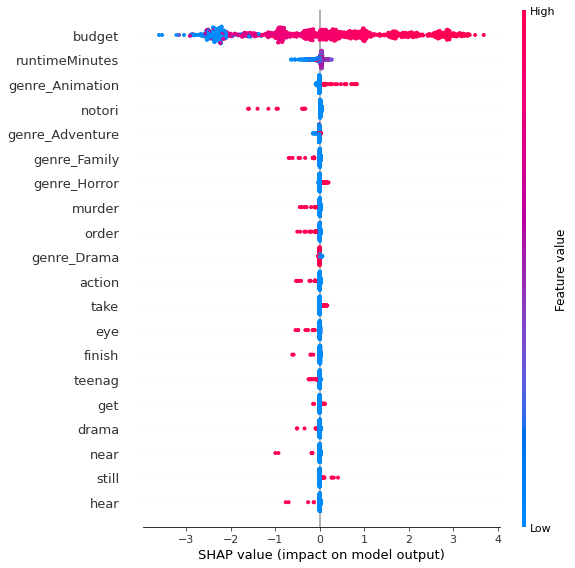

In [ ]:
shap.summary_plot(shap_values, x)

SHAP Summary Plot for the Top Genre Features with **Animation** and **Horror** leading the genres that push the revenue higher

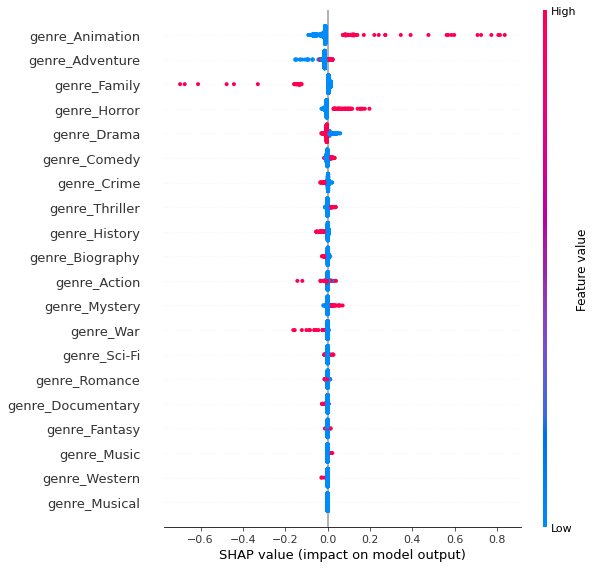

In [ ]:
shap.summary_plot(shap_values[:,colnum_genre], x.iloc[:, colnum_genre])

Based from the model, **Todd Philips** can potentially make the revenue higher.

He is nominated in the **Best Director - Motion Picture** and **Best Motion Picture of the Year** for the movie **Joker**


He also won **Best Foreign Feature Film** at the Amanda Awards in Norway



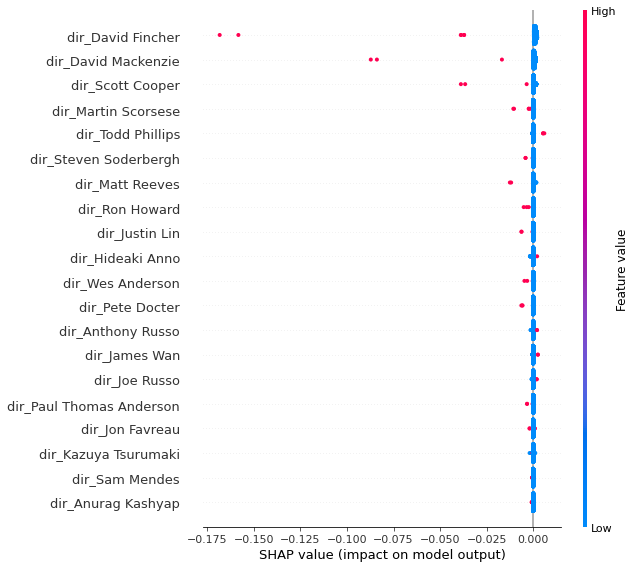

In [ ]:
shap.summary_plot(shap_values[:,colnum_dir], x.iloc[:, colnum_dir])

The top important actors/actresses are shown below

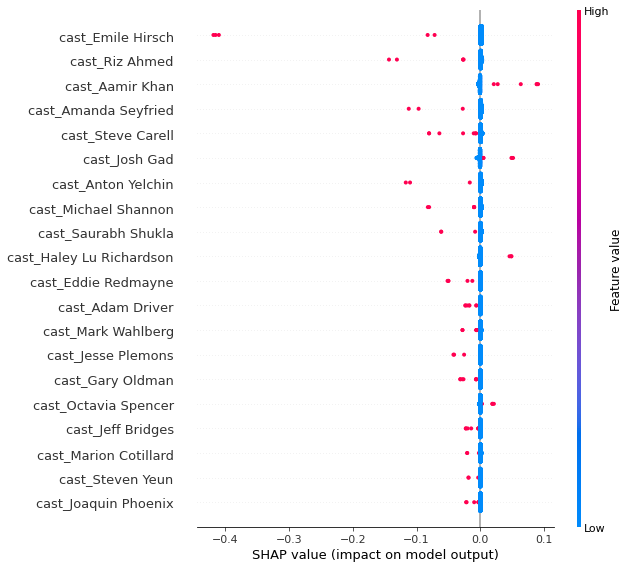

In [ ]:
shap.summary_plot(shap_values[:,colnum_cast], x.iloc[:, colnum_cast])

# **Next Hit Movie of 2021**

The recommendations to a movie studio director for the next hit movie of 2021 according to the model are:

*   Prepare the budget! Our model proves that budget is the **BIGGEST** factor for a movie to become "hit". Money will indeed influence how your movie is gonna look like
*   **Prolong** the movie **runtime**but not too long. Lower runtime movies tend to get much lower revenue according to our model.

*   Write a story with an **Animation** and/or **Horror** Genre

*   Study how **Todd Philips** directs his movies

*   Hire actors/actresses like **Aamir Khan**, **Josh Gad**, and **Haley Lu Richardson**
